In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch
from torch.utils.data import DataLoader
from torchvision import  datasets
from torchvision.transforms import transforms


In [2]:
batch_size = 128
lr = 0.0001
weight_decay = 0.00005
epoch = 100

In [3]:
data_tf = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root='\MNIST_data', train=True, transform=data_tf, download=False)
test_dataset = datasets.MNIST(root='\MNIST_data', train=False, transform=data_tf, download=False)
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=batch_size)

In [5]:
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 8, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=0),
            nn.ReLU(),
            nn.Flatten(start_dim=1)
        )
        self.encoder_lin = nn.Sequential(
            nn.Linear(32*3*3,64),
            nn.Linear(64,2)
        )
        self.decoder = nn.Sequential(
            nn.Unflatten(dim=1, unflattened_size=(32, 3, 3)),
            nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )
        self.decoder_lin = nn.Sequential(
            nn.Linear(2,64),
            nn.Linear(64,32*3*3)
        )
    def forward(self, x):
        x = self.encoder(x)
        encode = self.encoder_lin(x)
        x = self.decoder_lin(encode)
        decode = self.decoder(x)
        return encode, decode
criterion = nn.BCELoss()
#device = torch.device('cpu')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# 实例化一个模型，并迁移至gpu
#model = autoencoder().to(device)
model=torch.load('./autoencoder_noisy.pth').to(device)
optimizier = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

In [6]:
# 加噪声
def add_noise(input,noise_factor):
    x = np.array(input,dtype=np.float32)
    x_train_noisy = x + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x.shape)
    x_train_noisy = np.array(x_train_noisy,dtype=np.float32)
    train = torch.from_numpy(x_train_noisy)
    return train
        

In [25]:
model.train()
for i in range(epoch):
    for img, label in train_loader:
        img_noise = add_noise(img, 0.4)
        img = img.to(device)
        img_noise = img_noise.to(device)
        # forward
        _, output = model(img_noise)
        loss = criterion(output,img)
        # backward
        optimizier.zero_grad()
        loss.backward()
        optimizier.step()
    if (i+1) % 5 == 0:
        print("epoch: {}, loss is {:.4f}".format((i+1), loss.data))
torch.save(model, './autoencoder_noisy.pth')


epoch: 5, loss is 0.2795
epoch: 10, loss is 0.2229
epoch: 15, loss is 0.2084
epoch: 20, loss is 0.1992
epoch: 25, loss is 0.1976
epoch: 30, loss is 0.1886
epoch: 35, loss is 0.1955
epoch: 40, loss is 0.1932
epoch: 45, loss is 0.1933
epoch: 50, loss is 0.1896
epoch: 55, loss is 0.1979
epoch: 60, loss is 0.1873
epoch: 65, loss is 0.1938
epoch: 70, loss is 0.1843
epoch: 75, loss is 0.1943
epoch: 80, loss is 0.1906
epoch: 85, loss is 0.1937
epoch: 90, loss is 0.1853
epoch: 95, loss is 0.1737
epoch: 100, loss is 0.1947


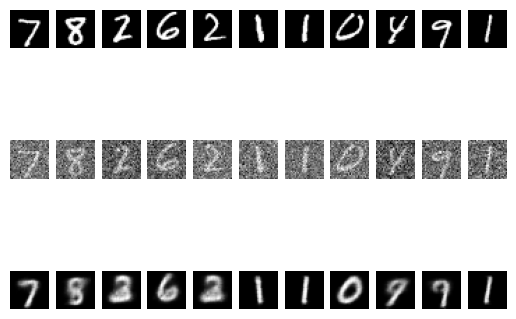

In [7]:
model.eval()
with torch.no_grad():
    i = 0
    for img, _ in test_loader:
        if i <= 10:
            img_noise = add_noise(img, 0.4)
            img = img.to(device)
            img_noise = img_noise.to(device)
            # forward
            _, output = model(img_noise)
            plt.subplot(3,11,i+1)
            plt.imshow(img[0][0].to('cpu'),cmap='gist_gray')
            plt.axis(False)
            plt.subplot(3,11,i+12)
            plt.imshow(img_noise[0][0].to('cpu'),cmap='gist_gray')
            plt.axis(False)
            plt.subplot(3,11,i+23)
            plt.imshow(output[0][0].to('cpu'),cmap='gist_gray')
            plt.axis(False)
        i += 1 
plt.show()